In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import roc_curve

from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, LSTM, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path ="/kaggle/input/brain-tumor-mri-dataset/Training"

In [3]:
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [4]:
classes = sorted(os.listdir(train_path))
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
def to_frame(path):
    class_types = []
    class_paths = []
    files = os.listdir(path)
    for file in files:
        label_dir = os.path.join(path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            class_name = os.path.splitext(file)[0]
            class_types.append(class_name)
    image_classes = pd.Series(class_types, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

In [6]:
train_df = to_frame(train_path)

In [7]:
test_df = to_frame(test_path)

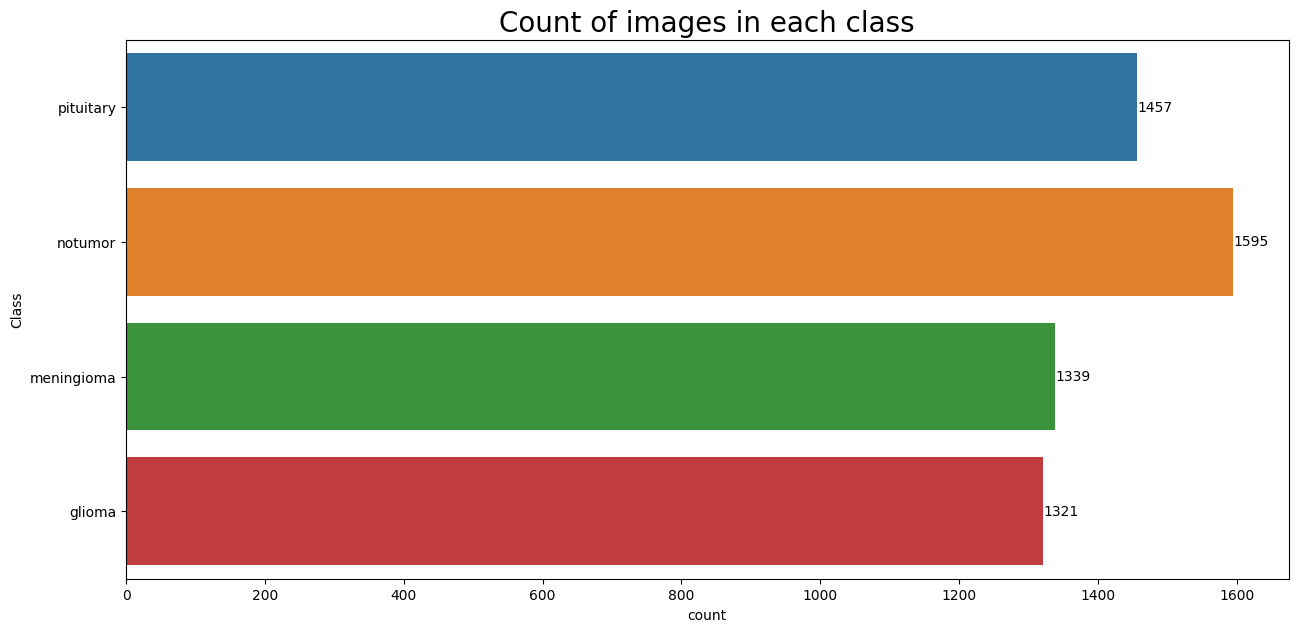

In [8]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Class'])
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [9]:
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])

In [10]:
valid_df

Class Path       Class
1297  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
723   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
61    /kaggle/input/brain-tumor-mri-dataset/Testing/...   pituitary
778   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
1120  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
...                                                 ...         ...
1070  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
554   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
1284  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
899   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
626   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor

[655 rows x 2 columns]

In [11]:
import os
augmented_train_dir = "/kaggle/working/Augmented_Training"
os.makedirs(augmented_train_dir, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(augmented_train_dir, class_name), exist_ok=True)


In [12]:
img_size = (299, 299)
batch_size = 32
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmentation generator for "no tumor" class
no_tumor_gen = ImageDataGenerator(
    rescale=1.0/255,
    brightness_range=(0.6, 1.4),  # Wider brightness range for more challenging samples
    rotation_range=30,            # Increased rotation for distinct variations
    width_shift_range=0.3,        # Increased width shift
    height_shift_range=0.3,       # Increased height shift
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmentation_factor = 2  # How many times to augment each image for "no tumor"
for class_name in classes:
    class_df = train_df[train_df['Class'] == class_name]
    save_dir = os.path.join(augmented_train_dir, class_name)
    os.makedirs(save_dir, exist_ok=True)

    # Apply augmentation only to the "no tumor" class
    if class_name == 'notumor':
        aug_flow = no_tumor_gen.flow_from_dataframe(
            class_df,
            x_col='Class Path',
            y_col='Class',
            target_size=img_size,
            batch_size=1,
            save_to_dir=save_dir,
            save_prefix=class_name,
            save_format='jpg'
        )
        
        # Generate augmented images for the "no tumor" class
        for i in range(len(class_df) * augmentation_factor):
            next(aug_flow)

Found 1595 validated image filenames belonging to 1 classes.


In [13]:
import os

no_tumor_dir = os.path.join(augmented_train_dir, 'notumor')
no_tumor_images = os.listdir(no_tumor_dir)
print(f"Total images in 'no tumor' class directory: {len(no_tumor_images)}")


Total images in 'no tumor' class directory: 3190


In [14]:
img_size = (299, 299)
batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

_gen = ImageDataGenerator(rescale=1.0/255, brightness_range=(0.8, 1.2),
                          rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                          shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                          fill_mode='nearest')
augmentation_factor = 3
for class_name in classes:
    class_df = train_df[train_df['Class'] == class_name]
    save_dir = os.path.join(augmented_train_dir, class_name)
    
    aug_flow = _gen.flow_from_dataframe(
        class_df,
        x_col='Class Path',
        y_col='Class',
        target_size=img_size,
        batch_size=1,
        save_to_dir=save_dir,
        save_prefix=class_name,
        save_format='jpg'
    )
    
    # Generate images to double the dataset size for this class
    for i in range(len(class_df) * augmentation_factor):
        next(aug_flow)

augmented_train_df = to_frame(augmented_train_dir)

train_gen = _gen.flow_from_dataframe(augmented_train_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)
test_gen = ImageDataGenerator(rescale=1.0/255)
valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, shuffle=False)



Found 1321 validated image filenames belonging to 1 classes.
Found 1339 validated image filenames belonging to 1 classes.
Found 1595 validated image filenames belonging to 1 classes.
Found 1457 validated image filenames belonging to 1 classes.
Found 20326 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [15]:
# Check the number of images in each DataFrame
print("Number of training images:", len(augmented_train_df))
print("Number of validation images:", len(valid_df))
print("Number of test images:", len(test_df))


Number of training images: 20326
Number of validation images: 655
Number of test images: 656


In [16]:
# Check the number of images in each generator
print("Number of images in training generator:", train_gen.n)
print("Number of images in validation generator:", valid_gen.n)
print("Number of images in test generator:", test_gen.n)


Number of images in training generator: 20326
Number of images in validation generator: 655
Number of images in test generator: 656


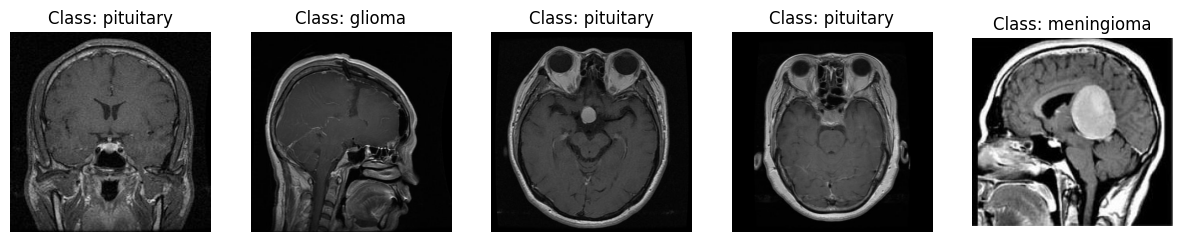

In [17]:
def display_random_images(df, num_images=5):
    random_indices = random.sample(range(len(df)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        image_path = df.loc[idx, 'Class Path']
        class_name = df.loc[idx, 'Class']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')
    plt.show()
display_random_images(train_df)

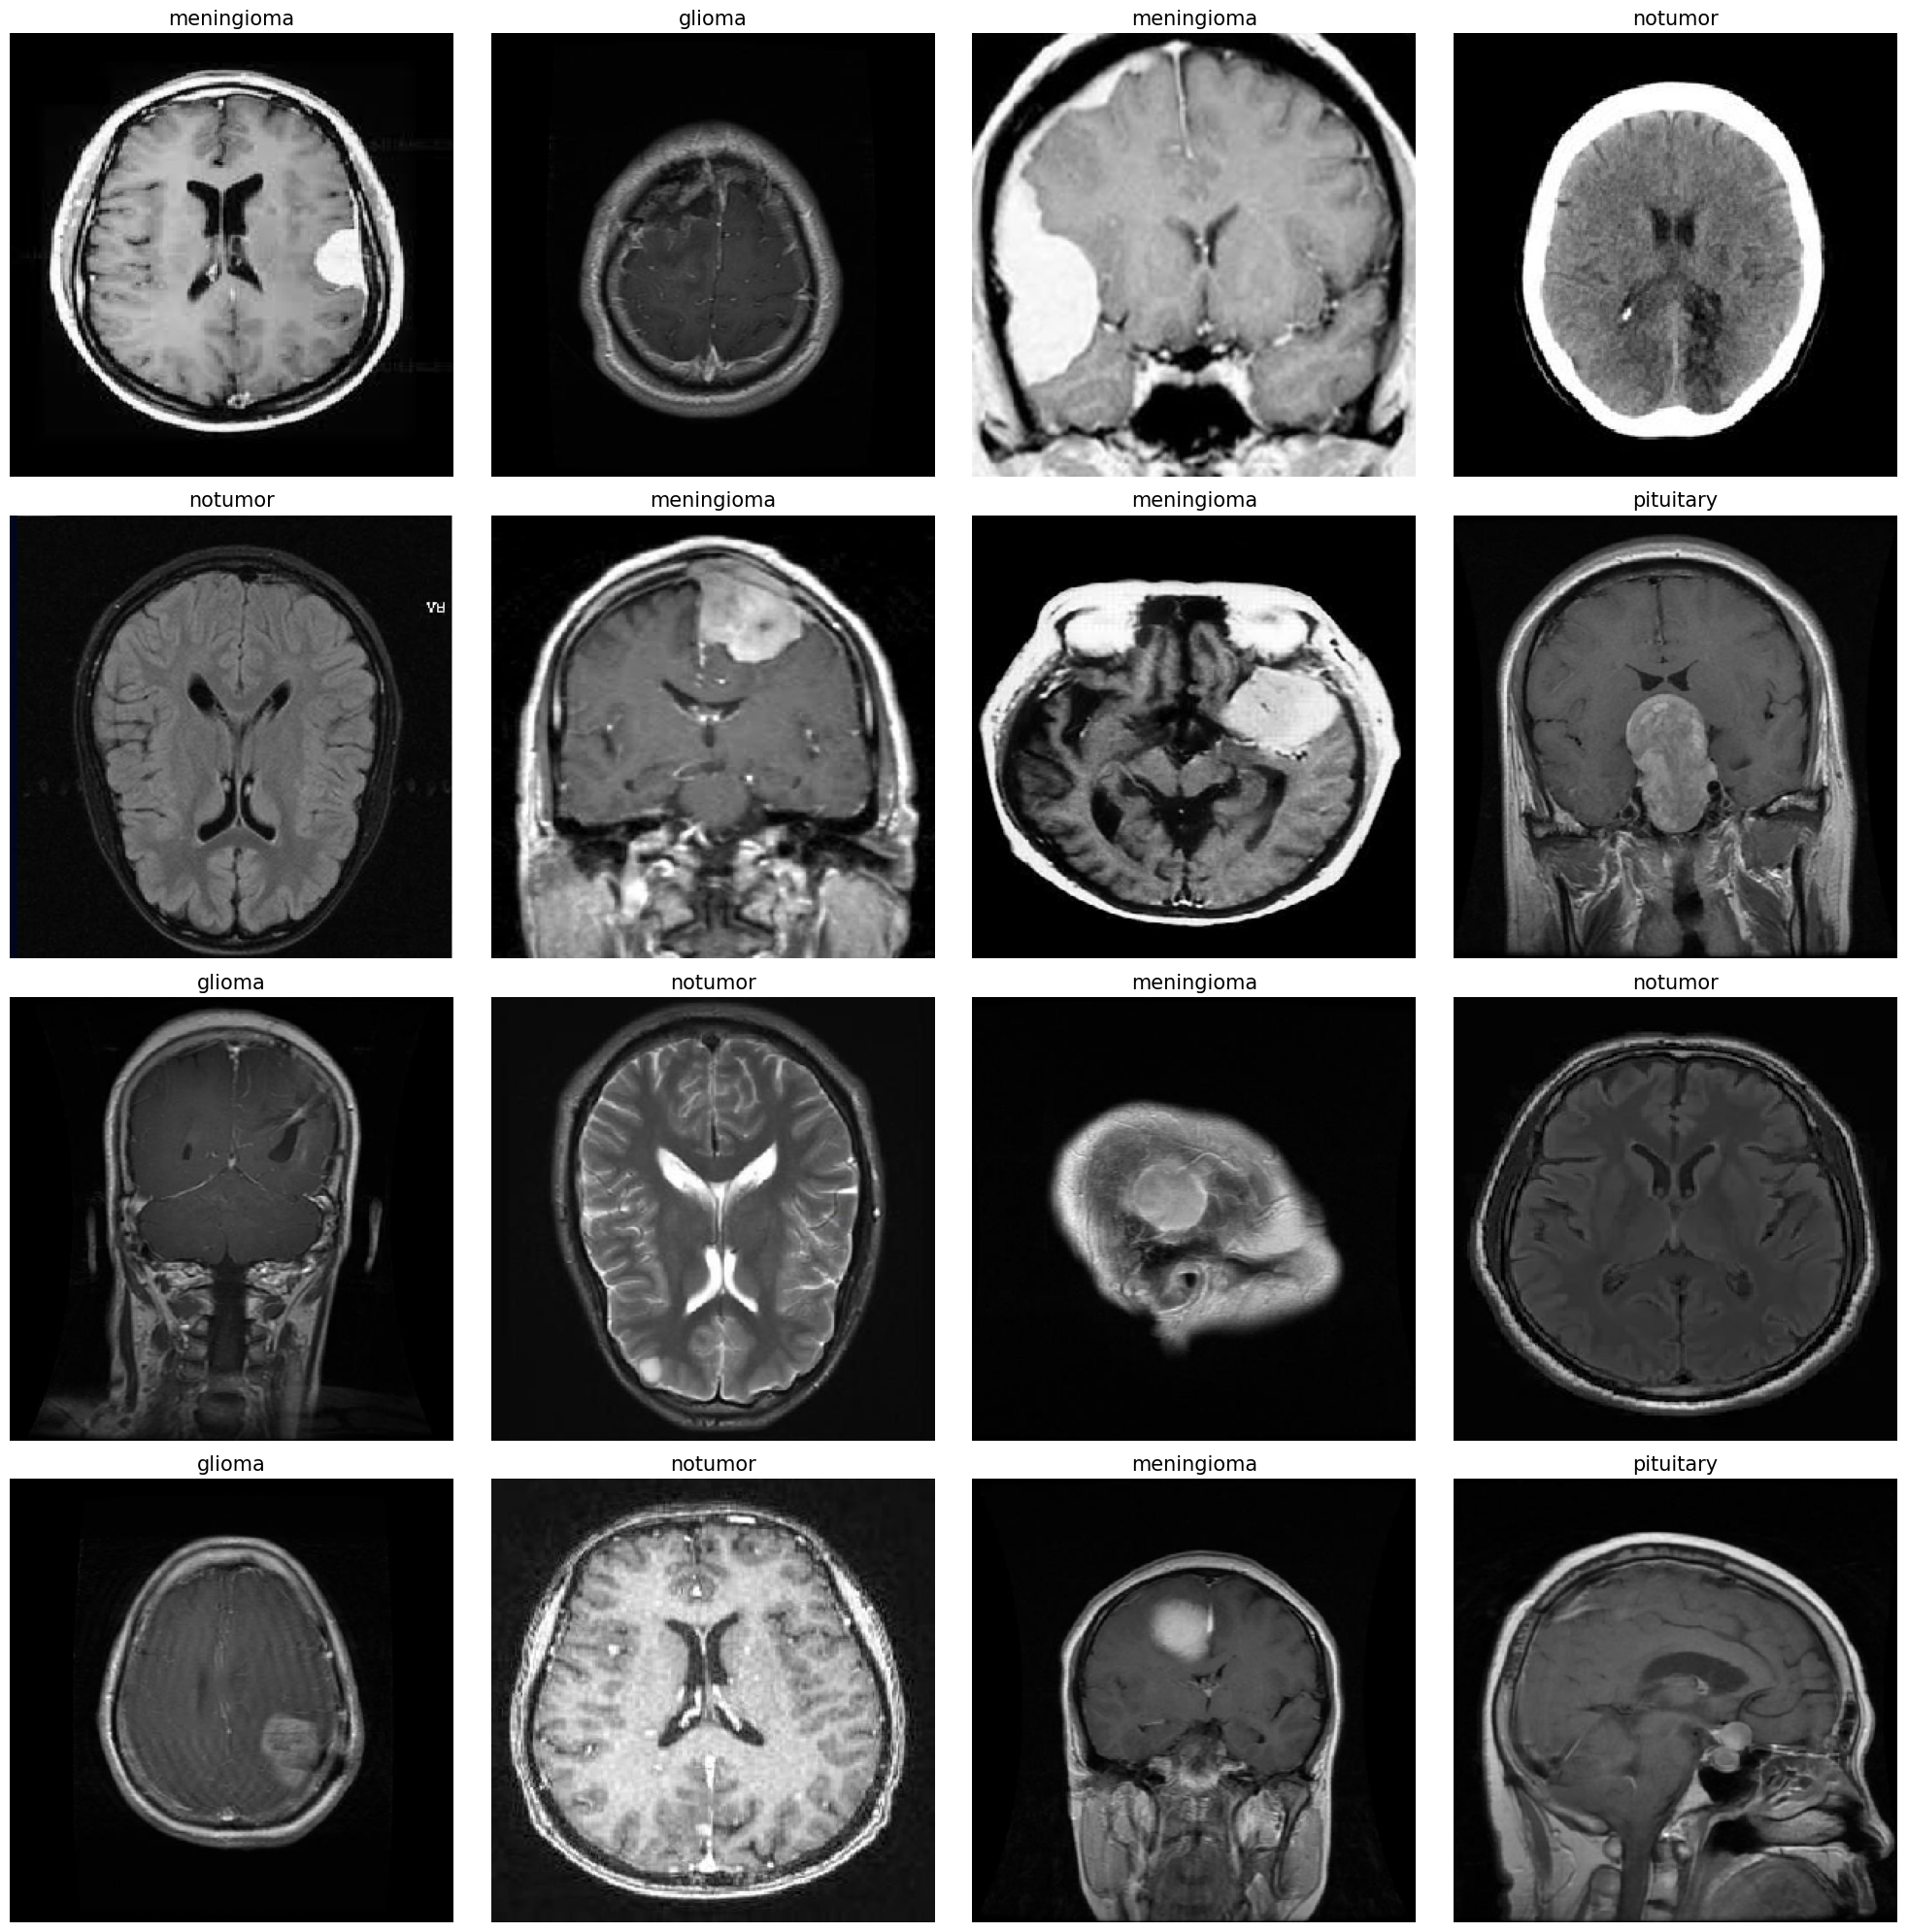

In [18]:
# class_dict = train_gen.class_indices
# classes = list(class_dict.keys())
# images, labels = next(test_gen)

# plt.figure(figsize=(20, 20))

# for i, (image, label) in enumerate(zip(images, labels)):
#     plt.subplot(4,4, i + 1)
#     plt.imshow(image)
#     class_name = classes[np.argmax(label)]
#     plt.title(class_name, color='k', fontsize=15)

# plt.show()

class_dict = train_gen.class_indices
classes = list(class_dict.keys())

# Get a batch of images and labels from the test generator
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

# Display a maximum of 16 images
num_images_to_display = min(len(images), 16)

for i in range(num_images_to_display):
    plt.subplot(4, 4, i + 1)  # Create a 4x4 grid of subplots
    plt.imshow(images[i])  # Display the image
    class_name = classes[np.argmax(labels[i])]  # Get the class name for the label
    plt.title(class_name, color='k', fontsize=15)  # Set the title with the class name
    plt.axis('off')  # Hide the axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

In [19]:
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
img_shape = (299, 299, 3)
# Load DenseNet models for feature extraction (without the final layers)
xception = Xception(include_top=False, weights="imagenet", input_shape=img_shape)
inceptionv3 = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape)


# Freeze the base models
for model in [xception,inceptionv3]:
    model.trainable = False


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Concatenate, Dropout, Dense, 
    BatchNormalization, Lambda, Conv2D, Multiply, Add, Reshape, Resizing
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Define the input shape
IMG_SIZE = (299, 299)
NUM_CLASSES = 4
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Load pre-trained Xception and InceptionV3 models
xception_model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
inception_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Extract features from each model (keep the 4D output)
features_xception = xception_model(input_tensor)    # Expected shape: (None, 10, 10, 2048)
features_inception = inception_model(input_tensor)  # Expected shape: (None, 8, 8, 2048)

# Resize InceptionV3 features to match Xception spatial dimensions (10x10)
resized_inception = Resizing(height=10, width=10, interpolation='bilinear')(features_inception)

# Concatenate the features from both models
concatenated_features = Concatenate()([features_xception, resized_inception])  # Shape: (None, 10, 10, 4096)

# Spatial Attention Module
def spatial_attention(x):
    avg_pool = Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return Multiply()([x, attention])

# Channel Attention Module
def channel_attention(x):
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = Lambda(lambda z: tf.reduce_max(z, axis=(1, 2)))(x)
    concat = Concatenate()([avg_pool, max_pool])
    dense = Dense(x.shape[-1] // 8, activation='relu')(concat)
    attention = Dense(x.shape[-1], activation='sigmoid')(dense)
    attention = Reshape((1, 1, x.shape[-1]))(attention)
    return Multiply()([x, attention])

# Apply spatial and channel attention
spatial_att = spatial_attention(concatenated_features)
channel_att = channel_attention(spatial_att)
attention_output = Add()([spatial_att, channel_att])

# Add dense layers
x = GlobalAveragePooling2D()(attention_output)  # Pool before the dense layers
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Build the model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'), 
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 8, 8,      │ 21,802,784 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 10, 10,    │ 20,861,480 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 10, 10,    │          0 │ inception_v3[0][… │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 10, 10,    │          0 │ xception[0][0],   │
│ (Concatenate)       │ 4096)             │            │ resizing[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 10, 10, 1) │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 10, 10, 1) │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 10, 10, 2) │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 10, 10, 1) │         99 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 10, 10,    │          0 │ concatenate_4[0]… │
│                     │ 4096)             │            │ conv2d_196[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4096)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 4096)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 8192)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  4,194,816 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4096)      │  2,101,248 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ dense_1[0][0]     │
│                     │ 4096)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 10, 10,    │          0 │ multiply[0][0],   │
│ (Multiply)          │ 4096)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 10, 10,    │          0 │ multiply[0][0],   │
│                     │ 4096)             │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4096)      │          0 │ add_24[0][0]    

 Total params: 51,126,831 (195.03 MB)

 Trainable params: 51,036,591 (194.69 MB)

 Non-trainable params: 90,240 (352.50 KB)

In [21]:
# Visualize the model's architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_flow.png', show_shapes=True, show_layer_names=True, dpi=300)


In [22]:
# Train the model
hist = model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

# Load the best model saved as .keras
model.load_weights('best_model.keras')

Epoch 1/5


I0000 00:00:1731661064.427258     102 service.cc:145] XLA service 0x7dfa7c0023c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731661064.427345     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731661170.781908     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


636/636 ━━━━━━━━━━━━━━━━━━━━ 821s 1s/step - accuracy: 0.7946 - loss: 1.6980 - precision: 0.8184 - recall: 0.7735 - val_accuracy: 0.9496 - val_loss: 1.1977 - val_precision: 0.9523 - val_recall: 0.9450 - learning_rate: 1.0000e-04
Epoch 2/5
636/636 ━━━━━━━━━━━━━━━━━━━━ 490s 761ms/step - accuracy: 0.9581 - loss: 1.1761 - precision: 0.9624 - recall: 0.9553 - val_accuracy: 0.9893 - val_loss: 1.0392 - val_precision: 0.9893 - val_recall: 0.9893 - learning_rate: 1.0000e-04
Epoch 3/5
636/636 ━━━━━━━━━━━━━━━━━━━━ 479s 744ms/step - accuracy: 0.9796 - loss: 1.0466 - precision: 0.9804 - recall: 0.9781 - val_accuracy: 0.9618 - val_loss: 1.0231 - val_precision: 0.9632 - val_recall: 0.9603 - learning_rate: 1.0000e-04
Epoch 4/5
636/636 ━━━━━━━━━━━━━━━━━━━━ 472s 734ms/step - accuracy: 0.9819 - loss: 0.9401 - precision: 0.9828 - recall: 0.9811 - val_accuracy: 0.9832 - val_loss: 0.8471 - val_precision: 0.9832 - val_recall: 0.9832 - learning_rate: 1.0000e-04
Epoch 5/5
636/636 ━━━━━━━━━━━━━━━━━━━━ 476s 739ms

In [23]:
hist.history.keys()


dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

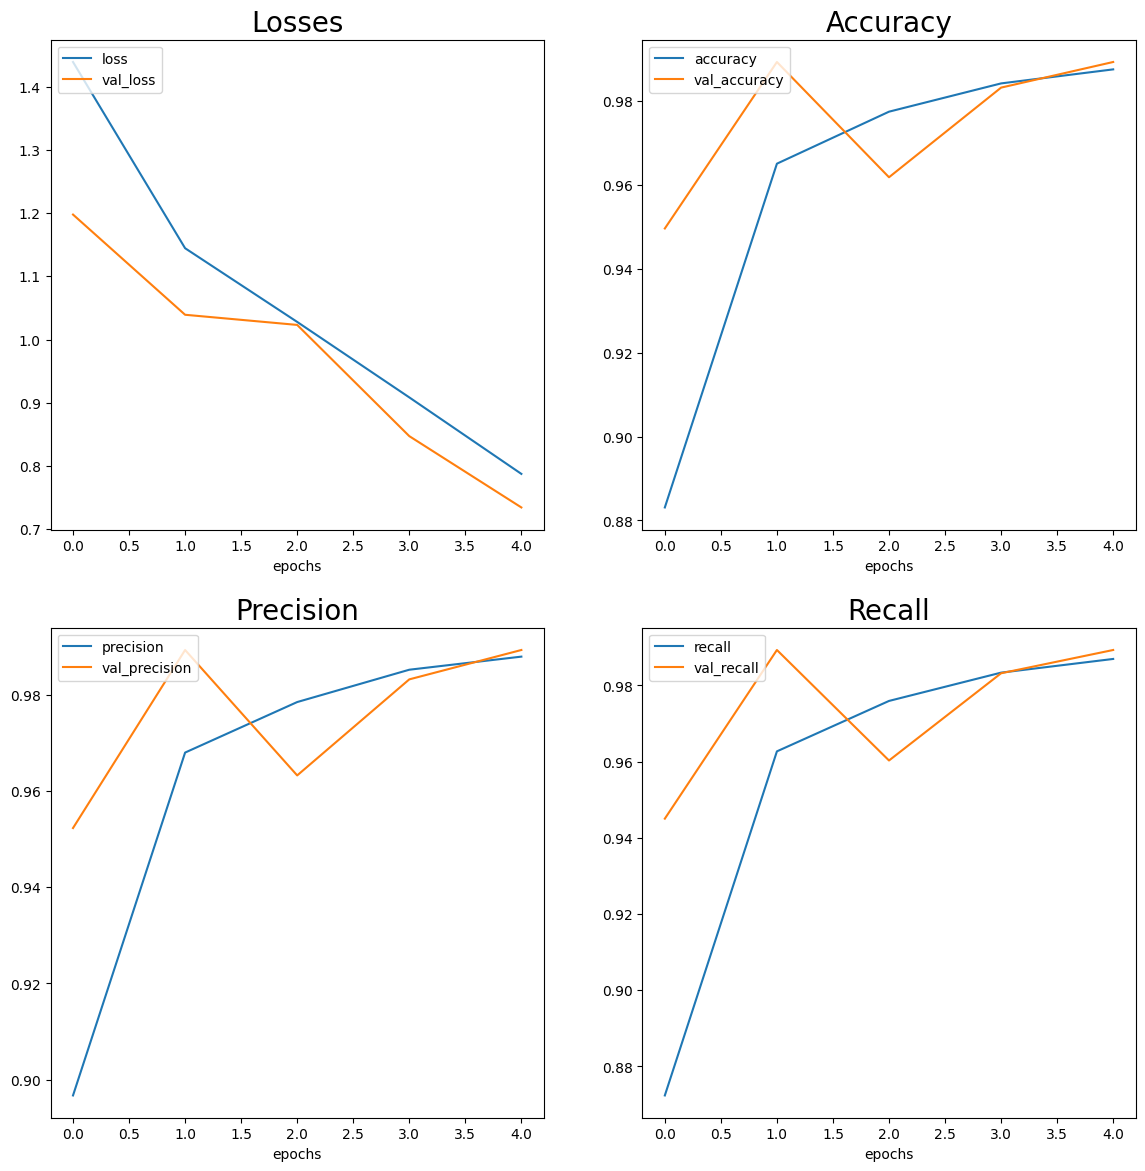

In [24]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")
plt.subplot(2, 2, 3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()


In [25]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

636/636 ━━━━━━━━━━━━━━━━━━━━ 445s 699ms/step - accuracy: 0.9952 - loss: 0.7065 - precision: 0.9954 - recall: 0.9949
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 716ms/step - accuracy: 0.9841 - loss: 0.7322 - precision: 0.9841 - recall: 0.9841
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 839ms/step - accuracy: 0.9895 - loss: 0.7184 - precision: 0.9895 - recall: 0.9890
Train Loss:  0.7082569003105164
Train Accuracy:  0.9938010573387146
--------------------
Validation Loss:  0.7306719422340393
Validation Accuracy:  0.981679379940033
--------------------
Test Loss:  0.7406119108200073
Test Accuracy:  0.9847561120986938


In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Generate predictions using the `predict` method
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Get true labels
y_true = test_gen.classes

# Get class names if not already defined
classes = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=classes, digits=2))



21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       150
  meningioma       0.99      0.95      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.96      0.99      0.97       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



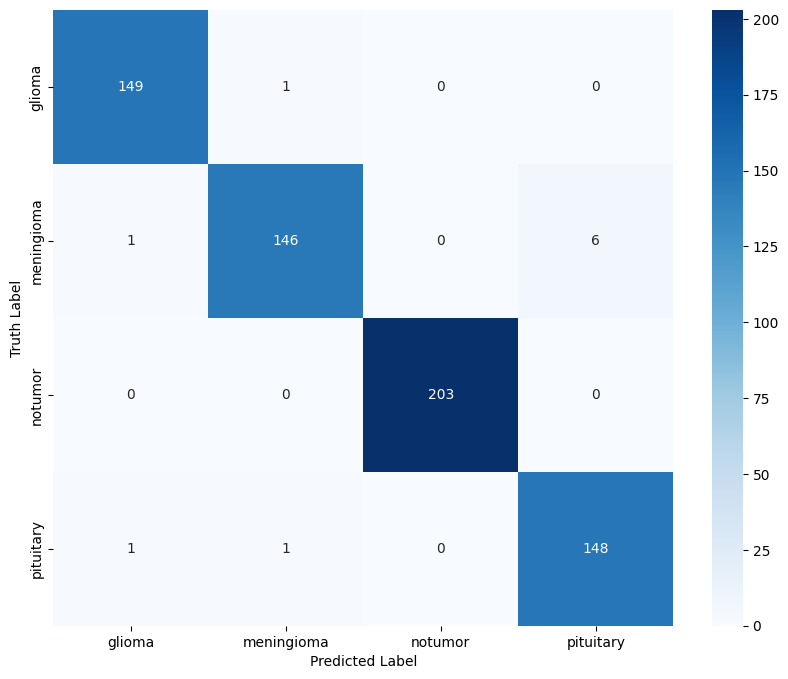

In [27]:
cm = confusion_matrix(test_gen.classes, y_pred)
labels = classes
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
images_test, labels_test = next(iter(test_gen))

for i in range(10):
    plt.imshow(images_test[i])
    plt.axis('off')

    prediction = np.argmax(model.predict(images_test[i][np.newaxis, ...]))
    actual_label = np.argmax(labels_test[i])  # Convert one-hot to index

    print(f"Predicted Label: {classes[prediction]} and Actual Label: {classes[actual_label]}")
    plt.show()